# Classifier-Free Guidance：扩散模型的"作弊码"

> 本文是对 [Sander Dieleman 博客文章](https://sander.ai/2022/05/26/guidance.html) 的中文概要总结

---

## 核心观点

**Classifier-Free Guidance（无分类器引导）** 是让 DALL·E 2、Imagen 等图像生成模型取得突破性进展的关键技术。它以极低的计算开销，大幅提升了条件生成的质量。

---

## 背景：Score Function 与贝叶斯法则

扩散模型预测的是 **score function**（分数函数）：

$$\nabla_x \log p(x)$$

通过贝叶斯法则，条件分布的 score 可以分解为：

$$\nabla_x \log p(x|y) = \nabla_x \log p(x) + \nabla_x \log p(y|x)$$

即：**无条件项** + **条件项**

---

## Classifier Guidance（分类器引导）

早期方法：训练一个单独的分类器 $p(y|x)$，用它的梯度来引导生成。

引入 **guidance scale**（引导强度）$\gamma > 1$：

$$\nabla_x \log p_\gamma(x|y) = \nabla_x \log p(x) + \gamma \cdot \nabla_x \log p(y|x)$$

放大 $\gamma$ 相当于对条件分布做"温度调节"，让生成结果更符合条件。

**缺点**：需要额外训练分类器，且分类器必须能处理带噪声的图像。

---

## Classifier-Free Guidance（无分类器引导）⭐

**核心创新**：不需要单独的分类器！

### 训练技巧：Conditioning Dropout

训练时随机丢弃条件信息（比如 10% 的概率不给文本提示），让同一个模型同时学会：
- 有条件生成：$\epsilon_\theta(x_t, y, t)$
- 无条件生成：$\epsilon_\theta(x_t, \varnothing, t)$

### 推理公式

$$\tilde{\epsilon} = (1 - \gamma) \cdot \epsilon_\theta(x_t, \varnothing, t) + \gamma \cdot \epsilon_\theta(x_t, y, t)$$

或等价地写成：

$$\tilde{\epsilon} = \epsilon_\theta(x_t, \varnothing, t) + \gamma \cdot \left[\epsilon_\theta(x_t, y, t) - \epsilon_\theta(x_t, \varnothing, t)\right]$$

**直觉理解**：
- $\gamma = 0$：完全无条件生成
- $\gamma = 1$：标准条件生成
- $\gamma > 1$：**放大**条件的影响，生成更符合提示词的图像

---

## 为什么扩散模型特别适合 Guidance？

扩散模型在**联合分布** $p(x|y)$ 上操作，而自回归模型在序列条件 $p(x_i|x_{<i}, y)$ 上操作。

这意味着扩散模型可以对整个图像施加全局引导，效果远优于逐 token 的引导。

---

## 实践要点

| 要点 | 说明 |
|------|------|
| **成本低** | Conditioning dropout 几乎不增加训练成本 |
| **效果显著** | 大幅提升生成质量和提示词遵循度 |
| **质量 vs 多样性** | Guidance 用多样性换质量，但条件本身已提供多样性 |
| **通用性强** | 适用于文本、类别标签、图像等各种条件 |

---

## 总结

> "Guidance 代表了我们生成感知信号能力的真正跃迁。"  
> — Sander Dieleman

Classifier-Free Guidance 是扩散模型领域最重要的技术创新之一，它解释了为什么近年来图像生成模型能取得如此惊人的效果。这项技术简单、高效、通用，堪比 Dropout 对深度学习的影响。

# CLIP 模型命名规则解析：clip-vit-large-patch14

## 命名拆解

```
clip - vit - large - patch14
 │     │      │       │
 │     │      │       └── 图像切分的 patch 大小：14×14 像素
 │     │      └────────── 模型规模：Large
 │     └───────────────── 视觉编码器架构：Vision Transformer
 └─────────────────────── 模型名称：CLIP
```

## 各部分详解

| 部分 | 含义 | 说明 |
|------|------|------|
| **CLIP** | Contrastive Language-Image Pre-training | OpenAI 的图文对比学习模型 |
| **ViT** | Vision Transformer | 视觉编码器使用 Transformer 架构（而非 CNN） |
| **Large** | 模型规模 | L 规模（还有 B=Base, H=Huge 等） |
| **Patch14** | Patch 大小 14×14 | 把图像切成 14×14 像素的小块输入 Transformer |

## Patch 的作用

```
┌──────────────────────────────┐
│  224×224 图像                │
│  ┌──┬──┬──┬──┬──┬──┬──┬──┐  │
│  │14│14│14│14│14│14│14│14│  │   224 ÷ 14 = 16
│  ├──┼──┼──┼──┼──┼──┼──┼──┤  │
│  │  │  │  │  │  │  │  │  │  │   共 16×16 = 256 个 patch
│  ├──┼──┼──┼──┼──┼──┼──┼──┤  │
│  │  │  │  │  │  │  │  │  │  │   每个 patch 作为一个 "token"
│  ...                        │   输入 Transformer
│  └──┴──┴──┴──┴──┴──┴──┴──┘  │
└──────────────────────────────┘
```

## 常见 CLIP 模型对比

| 模型名 | Embedding 维度 | Patch | 用于 |
|--------|---------------|-------|------|
| `ViT-B/32` | 512 | 32×32 | 轻量级 |
| `ViT-B/16` | 512 | 16×16 | 平衡 |
| `ViT-L/14` | **768** | 14×14 | **SD 1.x** |
| `ViT-H/14` | 1024 | 14×14 | SD 2.x |

---

**总结**：`clip-vit-large-patch14` = CLIP 模型 + ViT-Large 视觉编码器 + 14×14 patch，输出 **768 维** embedding，正是 Stable Diffusion 1.5 使用的 text encoder。

# 实现一个Stable Diffusion的pipe - Normal版

In [ ]:
# 查看 diffusers 库的版本信息
!pip show diffusers

In [ ]:
# ==================== 导入依赖库 ====================
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

# 禁用 warning 级别的日志，保持输出简洁
logging.disable(logging.WARNING)

# 设置随机种子，确保结果可复现
torch.manual_seed(1)

# 如果没有登录 Hugging Face，则弹出登录界面
# 需要登录才能下载某些模型
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [ ]:
# ==================== 生成参数配置 ====================

# 文本提示词列表，每个提示词会生成一张图片
prompts = [
    'a photograph of an astronaut riding a horse',          # 宇航员骑马的照片
    'an oil painting of an astronaut riding a horse in the style of grant wood'  # Grant Wood 风格的油画
]

height = 512                    # 生成图像高度（像素）
width = 512                     # 生成图像宽度（像素）
num_inference_steps = 70        # 去噪步数，越多质量越高但越慢
g = guidance_scale = 7.5        # CFG 引导强度，通常 7-8，越大越符合提示词
batch_size = 1                  # 批次大小
device = 'mps'                  # 计算设备：'cuda'(NVIDIA GPU) / 'mps'(Apple Silicon) / 'cpu'

In [ ]:
# ==================== 可视化 Beta Schedule ====================
# Beta 是每一步添加噪声的强度
# Stable Diffusion 使用 "scaled linear" schedule：
#   - 在平方根空间做线性插值，再平方回来
#   - 效果：早期 β 增长慢（精细处理细节），后期 β 增长快（快速建立结构）

beta_start, beta_end = 0.00085, 0.012  # SD 默认的 beta 起止值

# 绘制 beta schedule 曲线
# torch.linspace(sqrt(beta_start), sqrt(beta_end), 1000) ** 2
# = 在平方根空间线性插值后再平方，得到一条开口向上的抛物线
plt.plot(torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2)
plt.xlabel('Timestep')
plt.ylabel('β');

In [ ]:
# ==================== 加载 CLIP Text Encoder ====================
# CLIP 负责将文本提示词转换为 embedding 向量
# clip-vit-large-patch14 输出 768 维 embedding，与 SD 1.x 匹配

from transformers import CLIPTextModel, CLIPTokenizer

# Tokenizer: 将文本切分为 token（最多 77 个）
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)

# Text Encoder: 将 token 转换为 768 维的 embedding 向量
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to(device)

In [ ]:
# ==================== 加载 VAE 和 UNet ====================
from diffusers import AutoencoderKL, UNet2DConditionModel

# VAE (Variational Autoencoder): 
#   - Encoder: 将 512×512 图像压缩为 64×64×4 的潜空间表示（节省计算）
#   - Decoder: 将潜空间表示还原为 512×512 图像
# 这里使用经过更多步微调的 VAE，效果更好
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to(device)

# UNet: 核心去噪网络
#   - 输入: 噪声潜向量 + 文本 embedding + 时间步
#   - 输出: 预测的噪声
#   - 包含 Cross-Attention 层，让文本控制图像生成
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(device)

In [ ]:
# ==================== 创建 Scheduler ====================
# Scheduler 控制去噪过程中每一步如何更新 latents
# LMSDiscreteScheduler: 使用线性多步法（Linear Multi-Step），速度快且质量好

from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(
    beta_start=beta_start,          # β 起始值
    beta_end=beta_end,              # β 结束值
    beta_schedule="scaled_linear",  # 使用 scaled linear schedule（平方根空间线性）
    num_train_timesteps=1000        # 训练时的总时间步数
)

In [ ]:
# ==================== 编码文本提示词 (Conditional) ====================
# 将文本提示词转换为 CLIP embedding

# 1. Tokenize: 文本 → token IDs
#    padding="max_length": 填充到最大长度 77
#    truncation=True: 超过 77 则截断
text_input = tokenizer(
    prompts, 
    padding="max_length", 
    max_length=tokenizer.model_max_length,  # 77
    truncation=True, 
    return_tensors="pt"
)

# 2. Encode: token IDs → embedding 向量
#    输出形状: [batch_size, 77, 768]
#    - batch_size: 提示词数量
#    - 77: 最大 token 数
#    - 768: CLIP embedding 维度
text_embeddings = text_encoder(text_input.input_ids.to(device))[0].half()
text_embeddings.shape  # torch.Size([2, 77, 768])

In [ ]:
# ==================== 编码空提示词 (Unconditional) ====================
# Classifier-Free Guidance 需要同时计算：
#   - 有条件预测 (使用文本提示词)
#   - 无条件预测 (使用空字符串 "")

max_length = text_input.input_ids.shape[-1]  # 77

# 为每个 prompt 创建一个对应的空字符串
uncond_input = tokenizer(
    [""] * len(prompts),  # ["", ""] 两个空字符串
    padding="max_length", 
    max_length=max_length, 
    return_tensors="pt"
)

# 编码空字符串得到无条件 embedding
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0].half()

# 拼接无条件和有条件 embedding，方便一次前向传播
# emb = [uncond_emb_0, uncond_emb_1, cond_emb_0, cond_emb_1]
# 形状: [4, 77, 768] = [2个无条件 + 2个有条件, 77 tokens, 768 维]
emb = torch.cat([uncond_embeddings, text_embeddings])
emb.shape  # torch.Size([4, 77, 768])

In [ ]:
# ==================== 初始化 Latents (纯噪声) ====================
# 从纯高斯噪声开始，逐步去噪生成图像

torch.manual_seed(100)  # 固定种子，确保可复现

# 创建随机噪声作为初始 latents
# 形状: [batch_size, 4, height//8, width//8] = [2, 4, 64, 64]
#   - batch_size=2: 两个提示词
#   - 4: latent 通道数
#   - 64×64: 潜空间尺寸（原图 512×512 压缩 8 倍）
latents = torch.randn((len(prompts), unet.config.in_channels, height//8, width//8))

# 设置推理步数，scheduler 会自动计算时间步序列
scheduler.set_timesteps(num_inference_steps)

# 将 latents 移到设备并转为 float16
# 乘以 init_noise_sigma 是某些 scheduler 的要求，用于正确缩放初始噪声
latents = latents.to(device).half() * scheduler.init_noise_sigma

In [ ]:
from tqdm.auto import tqdm

  # 整体流程图

  # ┌─────────────────────────────────────────────────────────┐
  # │  for each timestep ts: 1000 → 0                         │
  # │                                                         │
  # │    latents ──┬──→ [latents, latents] ──→ UNet ─-─┐      │
  # │              │                            ↑      │      │
  # │              │     [uncond_emb, cond_emb]─┘      │      │
  # │              │                                   ↓      │
  # │              │                            [u, t]        │
  # │              │                                   ↓      │
  # │              │                     pred = u + g*(t-u)   │
  # │              │                                   ↓      │
  # │              └─────── scheduler.step ←───────────┘      │
  # │                            ↓                            │
  # │                     latents (更新后)                     │
  # └─────────────────────────────────────────────────────────┘

# 遍历所有时间步（如 1000 → 0），tqdm 显示进度条
for i,ts in enumerate(tqdm(scheduler.timesteps)):
    # latents:     [1, 4, 64, 64]
    #              ↓ 复制一份
    # cat结果:     [2, 4, 64, 64]  ← 一份给无条件，一份给有条件
    #              ↓ scale_model_input (某些scheduler需要缩放)
    # inp:         [2, 4, 64, 64]
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
    
    # with torch.no_grad():
    #     u, t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
    # emb 包含:    [uncond_emb, cond_emb]  ← 无条件 + 有条件 embedding

    # UNet 输出:   [2, 4, 64, 64]  预测的噪声
    #              ↓ chunk(2) 拆成两份
    # u:           [1, 4, 64, 64]  ← Unconditional 预测 (无条件)
    # t:           [1, 4, 64, 64]  ← Text-conditional 预测 (有条件)
    with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

    # Classifier-Free Guidance 核心公式！
    # pred = u + g * (t - u)
    #      = (1-g)*u + g*t      ← 等价形式
    #
    # g = guidance_scale (通常 7~8)
    #
    # 当 g = 1:  pred = t        (标准条件生成)
    # 当 g = 0:  pred = u        (无条件生成)
    # 当 g > 1:  pred 朝着 t 的方向"过度"移动 ← 放大条件影响
    pred = u + g*(t-u)

    # latents = scheduler.step(pred, ts, latents).prev_sample
    #  用预测的噪声 pred 更新 latents，向去噪方向前进一步
    latents = scheduler.step(pred, ts, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

ts:  tensor(999.)
ts:  tensor(984.5217)
ts:  tensor(970.0435)
ts:  tensor(955.5652)
ts:  tensor(941.0870)
ts:  tensor(926.6087)
ts:  tensor(912.1304)
ts:  tensor(897.6522)
ts:  tensor(883.1739)
ts:  tensor(868.6957)
ts:  tensor(854.2174)
ts:  tensor(839.7391)
ts:  tensor(825.2609)
ts:  tensor(810.7826)
ts:  tensor(796.3043)
ts:  tensor(781.8261)
ts:  tensor(767.3478)
ts:  tensor(752.8696)
ts:  tensor(738.3913)
ts:  tensor(723.9130)
ts:  tensor(709.4348)
ts:  tensor(694.9565)
ts:  tensor(680.4783)
ts:  tensor(666.)
ts:  tensor(651.5217)
ts:  tensor(637.0435)
ts:  tensor(622.5652)
ts:  tensor(608.0870)
ts:  tensor(593.6087)
ts:  tensor(579.1304)
ts:  tensor(564.6522)
ts:  tensor(550.1739)
ts:  tensor(535.6957)
ts:  tensor(521.2174)
ts:  tensor(506.7391)
ts:  tensor(492.2609)
ts:  tensor(477.7826)


In [ ]:
# ==================== VAE 解码：潜空间 → 像素空间 ====================
# 去噪完成后，latents 仍在潜空间（64×64×4），需要用 VAE Decoder 还原为真实图像

with torch.no_grad():
    # 1/0.18215 是 SD 训练时使用的缩放因子的倒数
    # 训练时 latents 被乘以 0.18215 压缩范围，推理时需要除回来
    # vae.decode() 将 64×64×4 的 latents 解码为 512×512×3 的图像
    image = vae.decode(1 / 0.18215 * latents).sample

# VAE 输出范围是 [-1, 1]，需要转换到 [0, 1] 用于显示
# image / 2 + 0.5: [-1, 1] → [0, 1]
# .clamp(0, 1): 裁剪越界值，确保在有效范围内
res = (image / 2 + 0.5).clamp(0, 1)

In [ ]:
# ==================== Tensor → PIL Image ====================
# res 形状: [batch_size, 3, 512, 512]，取第一张图

# res[0]: 取 batch 中的第一张图，形状 [3, 512, 512]
# .detach(): 从计算图中分离（不需要梯度）
# .cpu(): 从 GPU/MPS 移到 CPU（numpy 只能处理 CPU tensor）
# .permute(1, 2, 0): [C, H, W] → [H, W, C]，即 [3, 512, 512] → [512, 512, 3]
# .numpy(): 转为 numpy 数组
image = res[0].detach().cpu().permute(1, 2, 0).numpy()

# 将 [0, 1] 浮点数转为 [0, 255] 整数（uint8 是图像标准格式）
# * 255: [0, 1] → [0, 255]
# .round(): 四舍五入
# .astype("uint8"): 转为 8 位无符号整数
image = (image * 255).round().astype("uint8")

# 用 PIL 创建图像对象并显示
Image.fromarray(image)

In [ ]:
# ==================== Tensor → PIL Image ====================
# res 形状: [batch_size, 3, 512, 512]，取第一张图

# res[0]: 取 batch 中的第二张图，形状 [3, 512, 512]
# .detach(): 从计算图中分离（不需要梯度）
# .cpu(): 从 GPU/MPS 移到 CPU（numpy 只能处理 CPU tensor）
# .permute(1, 2, 0): [C, H, W] → [H, W, C]，即 [3, 512, 512] → [512, 512, 3]
# .numpy(): 转为 numpy 数组
image = res[1].detach().cpu().permute(1, 2, 0).numpy()

# 将 [0, 1] 浮点数转为 [0, 255] 整数（uint8 是图像标准格式）
# * 255: [0, 1] → [0, 255]
# .round(): 四舍五入
# .astype("uint8"): 转为 8 位无符号整数
image = (image * 255).round().astype("uint8")

# 用 PIL 创建图像对象并显示
Image.fromarray(image)

# 实现一个Stable Diffusion的pipe - PutInFunction

In [7]:
# ==================== 导入依赖库 ====================
import logging
from pathlib import Path

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

# 禁用 warning 级别的日志，保持输出简洁
logging.disable(logging.WARNING)

# 设置随机种子，确保结果可复现
torch.manual_seed(1)

# 如果没有登录 Hugging Face，则弹出登录界面
# 需要登录才能下载某些模型
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [4]:
# init settings
height = 512                    # 生成图像高度（像素）
width = 512                     # 生成图像宽度（像素）
device = 'mps'                  # 计算设备：'cuda'(NVIDIA GPU) / 'mps'(Apple Silicon) / 'cpu'

In [8]:
# ==================== 加载 CLIP Text Encoder ====================
# CLIP 负责将文本提示词转换为 embedding 向量
# clip-vit-large-patch14 输出 768 维 embedding，与 SD 1.x 匹配
from transformers import CLIPTextModel, CLIPTokenizer
# Tokenizer: 将文本切分为 token（最多 77 个）
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
# Text Encoder: 将 token 转换为 768 维的 embedding 向量
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to(device)

# ==================== 加载 VAE 和 UNet ====================
from diffusers import AutoencoderKL, UNet2DConditionModel
# VAE (Variational Autoencoder): 
#   - Encoder: 将 512×512 图像压缩为 64×64×4 的潜空间表示（节省计算）
#   - Decoder: 将潜空间表示还原为 512×512 图像
# 这里使用经过更多步微调的 VAE，效果更好
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to(device)
# UNet: 核心去噪网络
#   - 输入: 噪声潜向量 + 文本 embedding + 时间步
#   - 输出: 预测的噪声
#   - 包含 Cross-Attention 层，让文本控制图像生成
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(device)

# ==================== 创建 Scheduler ====================
# Scheduler 控制去噪过程中每一步如何更新 latents
# LMSDiscreteScheduler: 使用线性多步法（Linear Multi-Step），速度快且质量好
from diffusers import LMSDiscreteScheduler
# Beta 是每一步添加噪声的强度
# Stable Diffusion 使用 "scaled linear" schedule：
#   - 在平方根空间做线性插值，再平方回来
#   - 效果：早期 β 增长慢（精细处理细节），后期 β 增长快（快速建立结构）
beta_start, beta_end = 0.00085, 0.012  # SD 默认的 beta 起止值
scheduler = LMSDiscreteScheduler(
    beta_start=beta_start,          # β 起始值
    beta_end=beta_end,              # β 结束值
    beta_schedule="scaled_linear",  # 使用 scaled linear schedule（平方根空间线性）
    num_train_timesteps=1000        # 训练时的总时间步数
)

def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(device))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

def mk_samples(prompts, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(device).half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

/Users/bytedance/venv/lib/python3.13/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


/var/folders/k0/nlqc7vt13wd24wjjxks8w4f40000gn/T/ipykernel_38069/1439591033.py:55: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

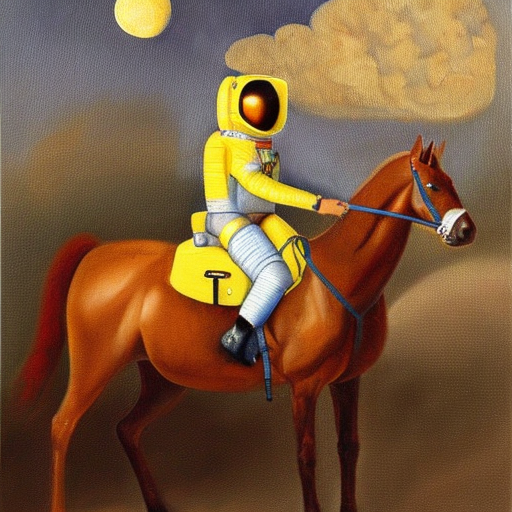

In [ ]:
prompts = [
    'a cat riding on a dog, and the dog ridding on a bicycle',  # 猫在狗上骑行，狗在自行车上骑行
    'a photograph of an astronaut riding a horse',          # 宇航员骑马的照片
    'an oil painting of an astronaut riding a horse in the style of grant wood'  # Grant Wood 风格的油画
]
images = mk_samples(prompts)


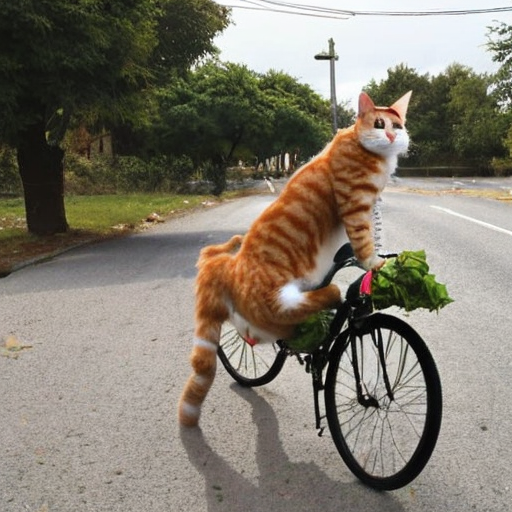

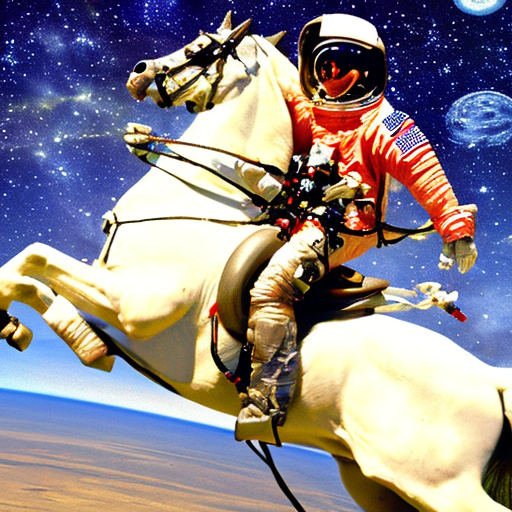

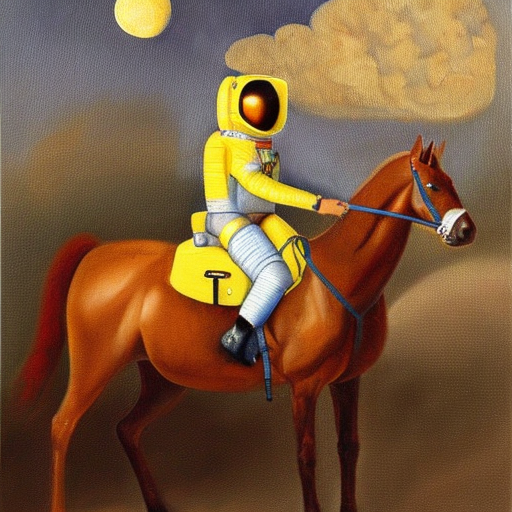

In [10]:
from IPython.display import display
# 遍历显示所有图片
for img in images: display(mk_img(img))